In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import tensorflow_io as tfio
from IPython.display import Audio

import noisereduce as nr



In [279]:
import pandas as pd
syllables_df = pd.read_pickle('/data0/home/h21/luas6629/Thesis/data/syllable_dfs/fruitbat_segmented/fruitbat_complete.pickle')


In [12]:
# max_length of audio

time_IQR = find_outlier_threshold(syllables_df.audio.apply(lambda x : x.shape[0]), k=1.5)
QR3_LENGTH = time_IQR[1] # set max length to upper 1.5 * Q3 quartile
print(QR3_LENGTH)

NameError: name 'find_outlier_threshold' is not defined

In [76]:
MAX_LENGTH = syllables_df.audio.apply(lambda x : x.shape[0]).max()

In [ ]:
250000 / 10750 

In [78]:
250000 / 23 => 16384

10869.565217391304

<Axes: >

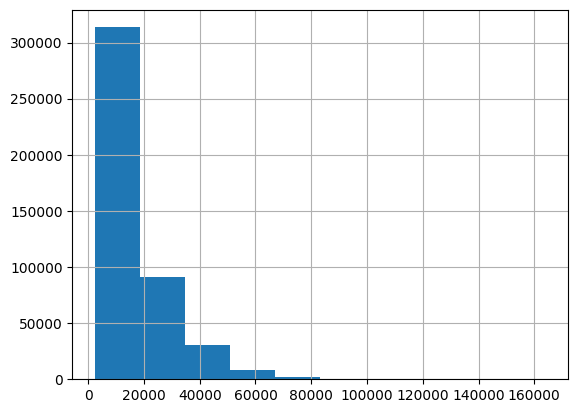

In [23]:
syllables_df.audio.apply(lambda x : x.shape[0]).hist()

In [79]:
sample_audio = syllables_df[syllables_df.audio.apply(lambda x : x.shape[0] > 150000)].audio.sample().values[0]




In [282]:
sample_audio.shape

(164125,)

In [ ]:
np.mean(time_IQR)

In [80]:
import tensorflow_io as tfio
from IPython.display import Audio

import noisereduce as nr



def power_to_db(S, amin=1e-16, top_db=80.0):
    """Convert a power-spectrogram (magnitude squared) to decibel (dB) units.
    Computes the scaling ``10 * log10(S / max(S))`` in a numerically
    stable way.
    Based on:
    https://librosa.github.io/librosa/generated/librosa.core.power_to_db.html
    """
    def _tf_log10(x):
        numerator = tf.math.log(x)
        denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
        return numerator / denominator
    
    # Scale magnitude relative to maximum value in S. Zeros in the output 
    # correspond to positions where S == ref.
    ref = tf.reduce_max(S)

    log_spec = 10.0 * _tf_log10(tf.maximum(amin, S))
    log_spec -= 10.0 * _tf_log10(tf.maximum(amin, ref))

    log_spec = tf.maximum(log_spec, tf.reduce_max(log_spec) - top_db)

    return log_spec




# Convert to tf.data.Dataset
#data = tf.data.Dataset.from_tensor_slices(np_data)

# Define your preprocessing function
def preprocess_data(audio_np):
    audio_tensor = tf.convert_to_tensor(audio_np, dtype=tf.float32)

    # Convert to spectrogram
    spectrogram = tfio.experimental.audio.spectrogram(audio_tensor, nfft=512, window=512, stride=256)

    # Convert to mel-spectrogram
    mel_spectrogram = tfio.experimental.audio.melscale(spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)

    # Convert to db scale mel-spectrogram
    dbscale_mel_spectrogram = tfio.experimental.audio.dbscale(mel_spectrogram, top_db=80)

    # Resize to a fixed size for model input
    image = tf.image.resize([dbscale_mel_spectrogram], [128, 128])

    return image


In [81]:
#sample_audio = syllables_df.audio.sample().values[0]
Audio(sample_audio, rate=192000)

In [ ]:
padded = np.pad(sample_audio, (0, (MAX_LENGTH - sample_audio.shape[0]).astype(int)), 'mean')
Audio(padded, rate=192000)

In [83]:
import noisereduce as nr

noise_processed = nr.reduce_noise(y=sample_audio, sr=250000, n_jobs = -1, )
Audio(noise_processed, rate=192000)

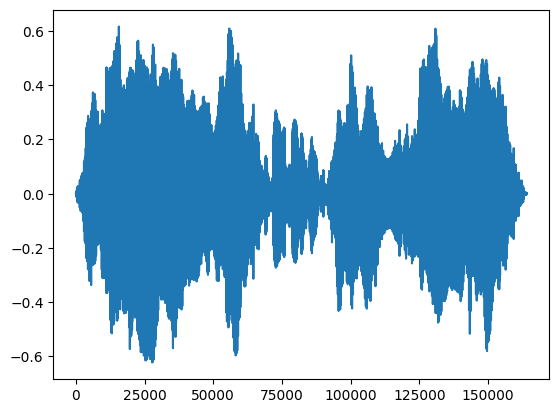

In [84]:
tensor = tf.cast(noise_processed, tf.float32)

plt.figure()
plt.plot(tensor.numpy())
Audio(tensor.numpy(), rate=192000)

tf.Tensor([  2945 160117], shape=(2,), dtype=int64)
tf.Tensor(2945, shape=(), dtype=int64) tf.Tensor(160117, shape=(), dtype=int64)
tf.Tensor(0.628688, shape=(), dtype=float64)


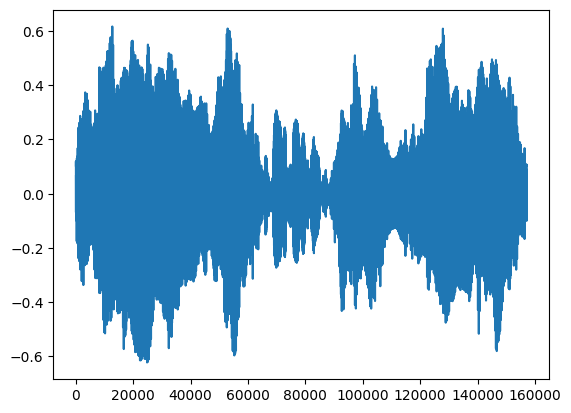

In [287]:
position = tfio.audio.trim(tensor, axis=0, epsilon=0.1)
print(position)

start = position[0]
stop = position[1]
print(start, stop)

processed = tensor[start:stop]

plt.figure()
plt.plot(processed.numpy())
print((stop - start)/250000)
Audio(processed.numpy(), rate=192000)


In [288]:
tfio.audio.trim(tensor, axis=0, epsilon=0.1)


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([  2945, 160117])>

In [ ]:
position = tfio.audio.trim(tensor, axis=0, epsilon=0.1)
start, stop = position

faded = tfio.audio.fade(
    tensor[:stop], 0, (tensor.shape[0] - tensor[stop:]), 'logarithmic'
)

plt.figure()
plt.plot(faded.numpy())
Audio(faded.numpy(), rate=192000)

In [ ]:
spectrogram = tfio.audio.spectrogram(
    tensor, nfft=512, window=512, stride=256)

plt.figure()
plt.imshow(tf.math.log(spectrogram).numpy())


# Convert to mel-spectrogram
mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate=32000, mels=20, fmin=0, fmax=16000)


plt.figure()
plt.imshow(tf.math.log(mel_spectrogram).numpy())

# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db=100)

plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy())

# convert to spectrograms

spectrograms = tf.signal.stft(tensor,
                              frame_length= 2048,
                              frame_step=64,
                              fft_length = 16384,
                              pad_end = True,
                              
                             )

magnitude_spectrograms = tf.abs(spectrograms)


plt.figure()
plt.imshow(magnitude_spectrograms.numpy())


# Create the Mel filterbank
mel_filterbank = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=1024,
    num_spectrogram_bins=8193,
    sample_rate=250000,
    lower_edge_hertz=500,
    upper_edge_hertz=125000,
)

plt.figure()
plt.imshow(mel_filterbank.numpy())

mel_power_spectrograms = tf.matmul(tf.square(magnitude_spectrograms),
                                mel_filterbank)

plt.figure()
plt.imshow(mel_power_spectrograms.numpy())




log_magnitude_mel_spectrograms = power_to_db(mel_power_spectrograms, amin=1e-16, top_db=120.0)


plt.figure()
plt.imshow(log_magnitude_mel_spectrograms.numpy())


In [290]:
log_magnitude_mel_spectrograms.numpy().shape

(2565, 1024)

In [ ]:
plt.matshow(log_magnitude_mel_spectrograms.numpy().T)

## DTW from 32x38 specs

In [4]:
import pandas as pd
syllables_df = pd.read_pickle('/data0/home/h21/luas6629/Thesis/data/syllable_dfs/fruitbat_segmented/fruitbat_complete.pickle')


In [614]:
syllables_df

start_time  end_time  indv  indvi    context                 key  \
0       0.1690    0.1840     0      0  Isolation  120709063505240110   
1       0.1965    0.2120     0      0  Isolation  120709063505240110   
2       0.2235    0.2420     0      0  Isolation  120709063505240110   
3       0.2520    0.2705     0      0  Isolation  120709063505240110   
4       0.2815    0.2980     0      0  Isolation  120709063505240110   
..         ...       ...   ...    ...        ...                 ...   
0       0.1270    0.1515  -210      0   Fighting  130413070116575204   
1       0.1905    0.2350  -210      0   Fighting  130413070116575204   
2       0.3000    0.3125  -210      0   Fighting  130413070116575204   
3       0.9055    0.9330  -210      0   Fighting  130413070116575204   
4       1.1025    1.1290  -210      0   Fighting  130413070116575204   

                                                audio    rate  \
0   [0.0008475364, -0.0023444185, 0.004395896, -0....  250000   
1   [-0.0047636633, 0.0027764626, -0.0007585912, 0...  250000   
2   [-0.0036426832, 0.0027627142, -0.0034103552, -...  250000   
3   [0.0039588124, 0.011923151, -0.010564981, 0.00...  250000   
4   [-0.0074556726, 0.006450946, 0.0012155158, 0.0...  250000   
..                                                ...     ...   
0   [0.13947959, 0.12543027, 0.03385169, 0.0036837...  250000   
1   [0.00110918, -0.003638754, -0.0031769671, -0.0...  250000   
2   [0.04478587, -0.026655957, -0.015254436, 0.028...  250000   
3   [-0.043910276, -0.030586425, -0.008700029, -0....  250000   
4   [-0.09583082, -0.022946868, -0.0992727, -0.022...  250000   

                                          spectrogram  
0   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
3   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
4   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
..                                                ...  
0   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.000462...  
1   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
3   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
4   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  

[445853 rows x 9 columns]

In [4]:
# NOTE - SEQUENCES are longer than ones parsed with earlier
#syllables_df.query(f'key in {list(map(str, [140219055925290410] ))}')

In [175]:
SEQUENCES = pd.read_pickle('/data0/home/h21/luas6629/Thesis/classifiers_bat_215/bat_215_repertoire.pkl')

In [176]:
SEQUENCES

syllableID_qt_ward  syllableID_et_ward  syllableID_hdbscan  \
segmentID                                                               
4871                       23                 330                  -1   
17492                       4                  78                  -1   
6422                       29                 396                  -1   
11093                      24                 334                  -1   
18219                      19                 274                   2   
...                       ...                 ...                 ...   
13022                      22                 321                   1   
7868                       26                 361                   3   
2328                       10                 167                  -1   
7706                       17                 239                   4   
11185                      22                 313                  -1   

           syllableID_hdb_nca  syllableID_ms label_context label_addressee  \
segmentID                                                                    
4871                        2              8            12             220   
17492                       5              1             9             208   
6422                        2              3            12             207   
11093                       3              8            12             207   
18219                       2              3             9             221   
...                       ...            ...           ...             ...   
13022                       1              6            12             207   
7868                        3              7            12             220   
2328                        4              0            12             220   
7706                        4              2            12             207   
11185                       5              1             9             207   

             FileID    Folder               File name  Pos_segment  
segmentID                                                           
4871       190320.0  files214  130215133639186520.WAV            0  
17492      274942.0  files223  130605065236566676.WAV            6  
6422       198860.0  files215  130225050249351835.WAV            3  
11093      240986.0  files219  130418070258624793.WAV            4  
18219      291755.0  files224  140217014554714274.WAV            1  
...             ...       ...                     ...          ...  
13022      250636.0  files220  130502114519368443.WAV            5  
7868       208325.0  files216  130307051132950918.WAV            2  
2328       162777.0  files211  130111111650417650.WAV            1  
7706       207326.0  files216  130306034047946739.WAV            4  
11185      241547.0  files219  130419060416470227.WAV            1  

[19300 rows x 11 columns]

## AE 32x38

In [178]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

_RANDOM_STATE = 0

In [40]:
bat_215 = syllables_df.query(f'indv in {[str(215)]}').copy()

In [177]:
bat_215;

In [ ]:
# Standard Scale, mean 0 and unit variance => was it already ???
# PCA
# AE tanh

In [103]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, quantile_transform

mm_scaler = MinMaxScaler()
st_scaler = StandardScaler()
rb_scaler = RobustScaler()

In [306]:
sample_specs = bat_215.sample(n =2 ).spectrogram
sample_1 = sample_specs.iloc[0]
sample_2 = sample_specs.iloc[1]


In [307]:
sample_1.mean()

0.09899383

In [586]:
sample_1[:,10]

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.4301301e-04, 2.3160095e-03, 8.2522798e-03, 1.9263085e-02,
       3.3341646e-02, 4.7753811e-02, 6.0373522e-02, 7.3256172e-02,
       1.1235151e-01, 1.9611055e-01, 2.7383915e-01, 3.0736396e-01,
       3.3636323e-01, 3.5791662e-01, 3.1041369e-01, 2.8656539e-01,
       3.4450671e-01, 3.8286573e-01, 4.2849395e-01, 4.1881436e-01,
       3.2549992e-01, 3.4502465e-01, 3.8925257e-01, 3.5812351e-01,
       2.7285087e-01, 1.5363257e-01, 1.5723623e-01, 1.5865660e-01],
      dtype=float32)

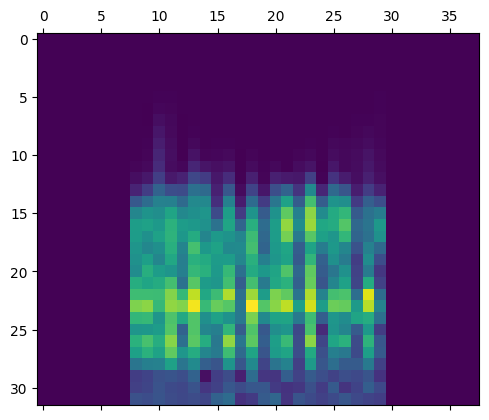

In [308]:
plt.matshow(sample_1)

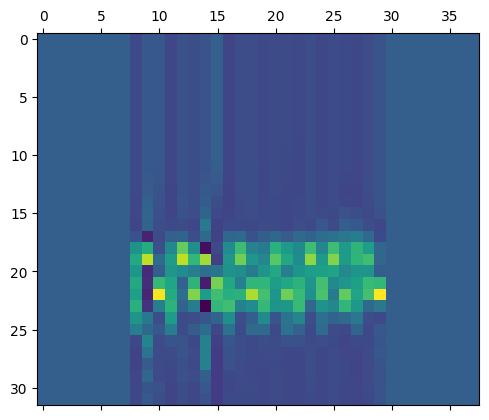

In [299]:
plt.matshow( st_scaler.fit_transform( sample_2 **2) )

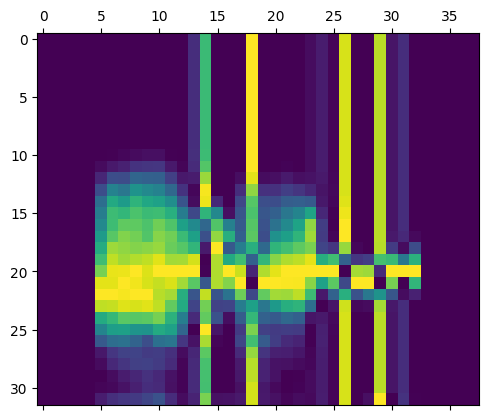

In [88]:
plt.matshow( mm_scaler.fit_transform( sample_1) )

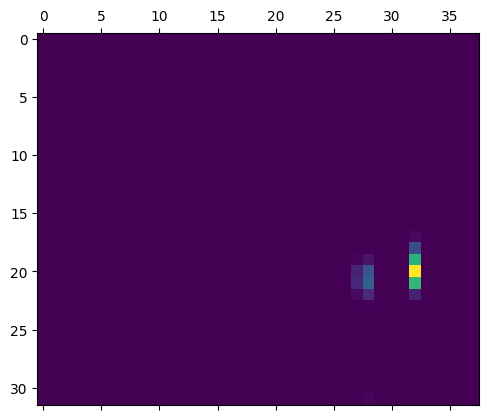

In [93]:
plt.matshow( rb_scaler.fit_transform( sample_1) )

/home/h21/luas6629/miniconda3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (32). n_quantiles is set to n_samples.
  warnings.warn(


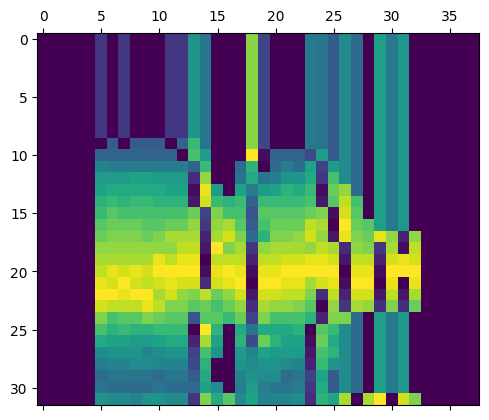

In [98]:
plt.matshow( quantile_transform( sample_1) )

In [589]:
X  = bat_215.spectrogram.apply(lambda x : (x - x.mean()) / (x.std() + 0.000000001) ).values

y = bat_215.context.values


In [590]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state= _RANDOM_STATE )


In [594]:
train_data = np.array([t.ravel() for t in X_train])
validation_data =  np.array([t.ravel() for t in X_test])

In [587]:
# """"" !!!!!!
# uses train_data from the other notebook...

In [599]:
train_data.reshape(train_data.shape[0], -1).shape

(18034, 1216)

In [561]:
np.array([t.T for t in train_data]).shape

(13508, 1024)

In [583]:
# what happen if I PCA over Transposed Spec ??
# (have not noticed nothing interesting)

In [600]:
train_data.shape

(18034, 1216)

In [601]:
%%time
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.decomposition import IncrementalPCA

pca = PCA(n_components= 0.85,  svd_solver = 'full')
pca_reducer = pca.fit(train_data.reshape(train_data.shape[0], -1))
train_pca = pca_reducer.transform(train_data.reshape(train_data.shape[0], -1))


validation_pca = pca_reducer.transform(validation_data.reshape(validation_data.shape[0], -1))
#test_pca = pca_reducer.transform(test_data.reshape(test_data.shape[0], -1))


CPU times: user 33.6 s, sys: 16.9 s, total: 50.5 s
Wall time: 1.81 s


In [602]:
# compoents
train_pca.shape , test_pca.shape

((18034, 36), (2896, 20))

In [530]:
#Reconstruct spectrogram using Inverse Transform PCA
spec_reconstructed = pca_reducer.inverse_transform(train_pca)

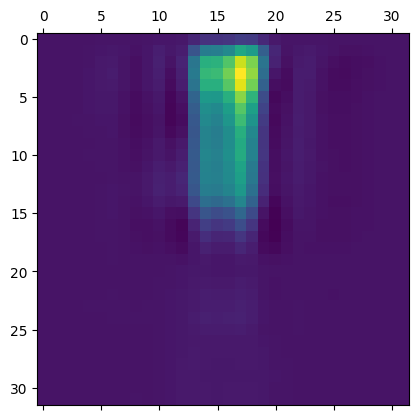

In [531]:
plt.matshow(spec_reconstructed[0].reshape(32,32))

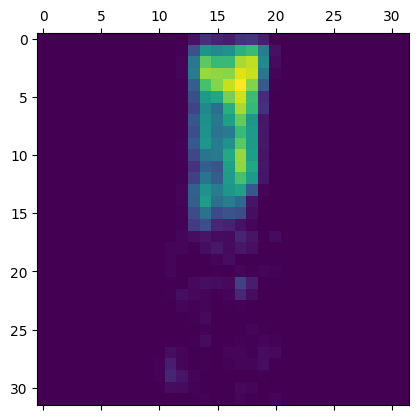

In [532]:
plt.matshow(train_data[0].reshape(32,32))

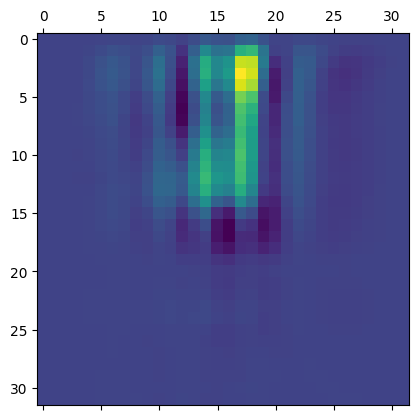

In [533]:
plt.matshow( pca_reducer.inverse_transform(st_scaler.fit_transform( train_pca )[0]).reshape(32,32))

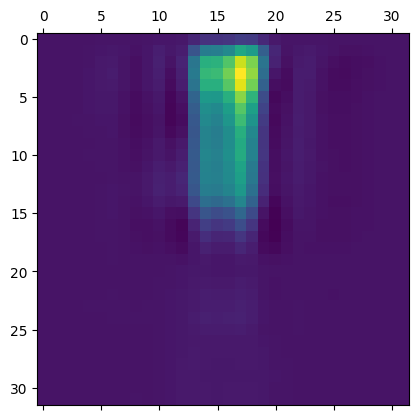

In [545]:
plt.matshow( pca_reducer.inverse_transform( train_pca[0] ).reshape(32,32))


In [395]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model


tf.debugging.set_log_device_placement(False)

tf.config.optimizer.set_jit(True)
tf.config.list_logical_devices('GPU')


[LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:GPU:1', device_type='GPU'),
 LogicalDevice(name='/device:GPU:2', device_type='GPU'),
 LogicalDevice(name='/device:GPU:3', device_type='GPU')]

In [603]:
#USING PCA ???

import umap
import umap.plot
from umap.parametric_umap import ParametricUMAP
from tensorflow.keras import regularizers

dims = (36,)
n_components = 2

tf.debugging.set_log_device_placement(True)


train_st_pca = st_scaler.fit_transform( train_pca )
validation_st_pca = st_scaler.fit_transform( validation_pca )



# Specify an invalid GPU device
with tf.device('/device:GPU:0'):

    encoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=dims),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units=8, activation="elu", kernel_regularizer=regularizers.l1(1e-5)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units=4, activation="elu", kernel_regularizer=regularizers.l1(1e-5)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units=n_components, kernel_regularizer=regularizers.l1(1e-5)),
    ])

    decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(n_components,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units=4, activation="elu", kernel_regularizer=regularizers.l1(1e-5)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units=8, activation="elu", kernel_regularizer=regularizers.l1(1e-5)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units=dims[0], activation="tanh", kernel_regularizer=regularizers.l1(1e-5)),
    ])
    
    ae_small_embedder = ParametricUMAP(

        # setting for UMAP NN
        metric = 'euclidean',
        min_dist = 0., 
        n_neighbors= 30,
        random_state=0,
        n_jobs = -1,
        n_components=2,

        # settings for the AE model
        optimizer =  tf.keras.optimizers.Adam(),
        encoder=encoder,
        decoder=decoder,
        dims=dims,
        batch_size = 2000,

        # losses and trainings
        n_training_epochs=1,

        parametric_reconstruction_loss_fcn = tf.keras.losses.MSE, 
        parametric_reconstruction= True,
        autoencoder_loss = True,
        reconstruction_validation=validation_st_pca,
        verbose=True,

        # try mitigate overfitting
        keras_fit_kwargs = {"callbacks": [
            tf.keras.callbacks.EarlyStopping(
                monitor='loss',
                min_delta=10**-2,
                patience=10,
                verbose=1,
            )
        ]}


    )

    
    ae_small_embedding = ae_small_embedder.fit_transform(train_st_pca)

ParametricUMAP(autoencoder_loss=True, batch_size=2000, decoder=<keras.engine.sequential.Sequential object at 0x7fa6b9d9dd50>, dims=(36,), encoder=<keras.engine.sequential.Sequential object at 0x7fa6b8b55d20>, keras_fit_kwargs={'callbacks': [<keras.callbacks.EarlyStopping object at 0x7fa6b9ccae60>]}, optimizer=<keras.optimizers.adam.Adam object at 0x7fa6b8b56980>, parametric_reconstruction=True, parametric_reconstruction_loss_fcn=<function mean_squared_error at 0x7fb627b660e0>, reconstruction_validation=array([[-1.2893894 , 0.73218834, -0.03940516, ..., 0.68454903,
         0.18643156, 0.14004456],
       [-0.16808344, -0.6547923 , 0.3962238 , ..., -4.259739  ,
         1.8545034 , -0.2013345 ],
       [ 2.2423728 , 0.2786906 , 0.39294335, ..., -0.7354518 ,
         0.4999285 , 0.12990198],
       ...,
       [ 1.0015709 , -0.93835896, -0.00440121, ..., -0.3897505 ,
         0.32807904, 0.3689079 ],
       [-0.6942663 , -0.33489734, -0.5926861 , ..., -0.11475316,
        -0.06318682, 0.

/home/h21/luas6629/miniconda3/lib/python3.10/site-packages/umap/parametric_umap.py:375: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  warn(


Epoch 1/10


2023-06-26 16:47:17.651955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [32065806]
	 [[{{node Placeholder/_1}}]]
2023-06-26 16:47:17.652397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [32065806]
	 [[{{node Placeholder/_1}}]]
2023-06-26 16:47:18.302669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim

1603/1603 [==============================] - 27s 11ms/step - loss: 1.1354 - reconstruction_loss: 0.7740 - umap_loss: 0.3601 - val_loss: 0.9253 - val_reconstruction_loss: 0.9240 - val_umap_loss: 0.0000e+00
Epoch 2/10
1603/1603 [==============================] - 17s 10ms/step - loss: 1.0399 - reconstruction_loss: 0.7295 - umap_loss: 0.3090 - val_loss: 0.8820 - val_reconstruction_loss: 0.8806 - val_umap_loss: 0.0000e+00
Epoch 3/10
1603/1603 [==============================] - 17s 11ms/step - loss: 1.0182 - reconstruction_loss: 0.7145 - umap_loss: 0.3022 - val_loss: 0.8642 - val_reconstruction_loss: 0.8628 - val_umap_loss: 0.0000e+00
Epoch 4/10
1603/1603 [==============================] - 17s 11ms/step - loss: 1.0094 - reconstruction_loss: 0.7082 - umap_loss: 0.2998 - val_loss: 0.8619 - val_reconstruction_loss: 0.8604 - val_umap_loss: 0.0000e+00
Epoch 5/10
1603/1603 [==============================] - 17s 10ms/step - loss: 1.0071 - reconstruction_loss: 0.7067 - umap_loss: 0.2989 - val_loss: 

Text(0.5, 1.0, 'Parametric UMAP - FFN - PCA-AE - Reconstruction Loss')

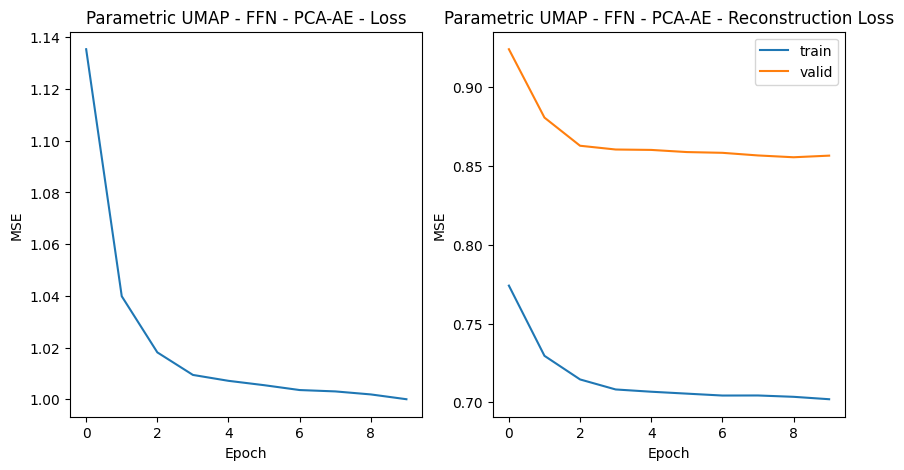

In [604]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
ax = axs[0]
ax.plot(ae_small_embedder._history['loss'])
ax.set_ylabel('MSE')
ax.set_xlabel('Epoch')
ax.set_title('Parametric UMAP - FFN - PCA-AE - Loss')

ax = axs[1]
ax.plot(ae_small_embedder._history['reconstruction_loss'], label='train')
ax.plot(ae_small_embedder._history['val_reconstruction_loss'], label='valid')
ax.legend()
ax.set_ylabel('MSE')
ax.set_xlabel('Epoch')
ax.set_title('Parametric UMAP - FFN - PCA-AE - Reconstruction Loss')

In [326]:
import umap
import umap.plot
from umap.parametric_umap import ParametricUMAP

dims = (32, 38, 1)
n_components = 2

tf.debugging.set_log_device_placement(True)


# Specify an invalid GPU device
with tf.device('/device:GPU:0'):

    encoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=dims),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=512, activation="elu"),
        tf.keras.layers.Dense(units=128, activation="elu"),
        tf.keras.layers.Dense(units=n_components, name="bottleneck"),
    ])

    decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(n_components,)),
        tf.keras.layers.Dense(units=128, activation="elu"),
        tf.keras.layers.Dense(units=512, activation="elu"),
        tf.keras.layers.Dense(units=np.prod(dims[0:2]), activation="tanh"),
        tf.keras.layers.Reshape(target_shape=(dims[0], dims[1], 1)),
    ])


    ae_small_embedder = ParametricUMAP(

        # setting for UMAP NN
        metric = 'euclidean',
        min_dist = 0., 
        n_neighbors= 30,
        random_state=0,
        n_jobs = -1,
        n_components=2,

        # settings for the AE model
        optimizer =  tf.keras.optimizers.Adam(),
        encoder=encoder,
        decoder=decoder,
        dims=dims,
        batch_size = 512,

        # losses and trainings
        n_training_epochs=1,

        parametric_reconstruction_loss_fcn = tf.keras.losses.MSE, 
        parametric_reconstruction= True,
        autoencoder_loss = True,
        reconstruction_validation=validation_data,
        verbose=True,

        # try mitigate overfitting
        keras_fit_kwargs = {"callbacks": [
            tf.keras.callbacks.EarlyStopping(
                monitor='loss',
                min_delta=10**-2,
                patience=10,
                verbose=1,
            )
        ]}


    )


    ae_small_embedding = ae_small_embedder.fit_transform(train_data.reshape(train_data.shape[0], -1))

ParametricUMAP(autoencoder_loss=True, batch_size=512, decoder=<keras.engine.sequential.Sequential object at 0x7fae36771e40>, dims=(32, 38, 1), encoder=<keras.engine.sequential.Sequential object at 0x7fae77495ae0>, keras_fit_kwargs={'callbacks': [<keras.callbacks.EarlyStopping object at 0x7fae36773b20>]}, optimizer=<keras.optimizers.adam.Adam object at 0x7faf4e7824a0>, parametric_reconstruction=True, parametric_reconstruction_loss_fcn=<function mean_squared_error at 0x7fb627b660e0>, reconstruction_validation=array([[[-0.555718  , -0.555718  , -0.555718  , ..., -0.555718  ,
         -0.555718  , -0.555718  ],
        [-0.555718  , -0.555718  , -0.555718  , ..., -0.555718  ,
         -0.555718  , -0.555718  ],
        [-0.555718  , -0.555718  , -0.555718  , ..., -0.555718  ,
         -0.555718  , -0.555718  ],
        ...,
        [-0.555718  , -0.555718  , -0.555718  , ..., -0.555718  ,
         -0.555718  , -0.555718  ],
        [-0.555718  , -0.555718  , -0.555718  , ..., -0.555718  ,


/home/h21/luas6629/miniconda3/lib/python3.10/site-packages/umap/parametric_umap.py:375: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  warn(
2023-06-26 13:50:31.561817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5720054]
	 [[{{node Placeholder/_1}}]]
2023-06-26 13:50:31.562263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5720054]
	 [[{{node Placeholder/_1}}]]


Epoch 1/10


2023-06-26 13:50:32.110079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]


1117/1117 [==============================] - 17s 12ms/step - loss: 0.8028 - reconstruction_loss: 0.4604 - umap_loss: 0.3424 - val_loss: 0.5019 - val_reconstruction_loss: 0.5019 - val_umap_loss: 0.0000e+00
Epoch 2/10
1117/1117 [==============================] - 12s 11ms/step - loss: 0.7664 - reconstruction_loss: 0.4463 - umap_loss: 0.3201 - val_loss: 0.4633 - val_reconstruction_loss: 0.4633 - val_umap_loss: 0.0000e+00
Epoch 3/10
1117/1117 [==============================] - 11s 10ms/step - loss: 0.7586 - reconstruction_loss: 0.4435 - umap_loss: 0.3152 - val_loss: 0.4645 - val_reconstruction_loss: 0.4645 - val_umap_loss: 0.0000e+00
Epoch 4/10
1117/1117 [==============================] - 12s 11ms/step - loss: 0.7511 - reconstruction_loss: 0.4411 - umap_loss: 0.3100 - val_loss: 0.4599 - val_reconstruction_loss: 0.4599 - val_umap_loss: 0.0000e+00
Epoch 5/10
1117/1117 [==============================] - 12s 10ms/step - loss: 0.7444 - reconstruction_loss: 0.4391 - umap_loss: 0.3053 - val_loss: 

Text(0.5, 1.0, 'Parametric UMAP - FFN-AE - Reconstruction Loss')

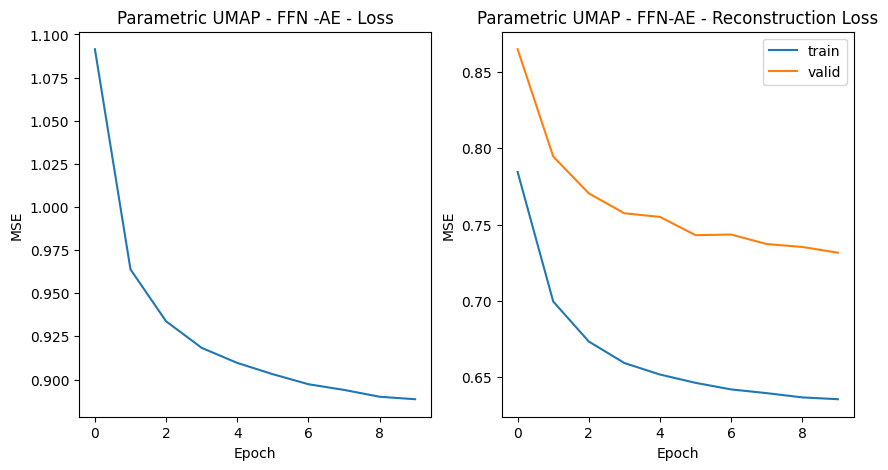

In [566]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
ax = axs[0]
ax.plot(T_ae_small_embedder._history['loss'])
ax.set_ylabel('MSE')
ax.set_xlabel('Epoch')
ax.set_title('Parametric UMAP - FFN -AE - Loss')

ax = axs[1]
ax.plot(T_ae_small_embedder._history['reconstruction_loss'], label='train')
ax.plot(T_ae_small_embedder._history['val_reconstruction_loss'], label='valid')
ax.legend()
ax.set_ylabel('MSE')
ax.set_xlabel('Epoch')
ax.set_title('Parametric UMAP - FFN-AE - Reconstruction Loss')

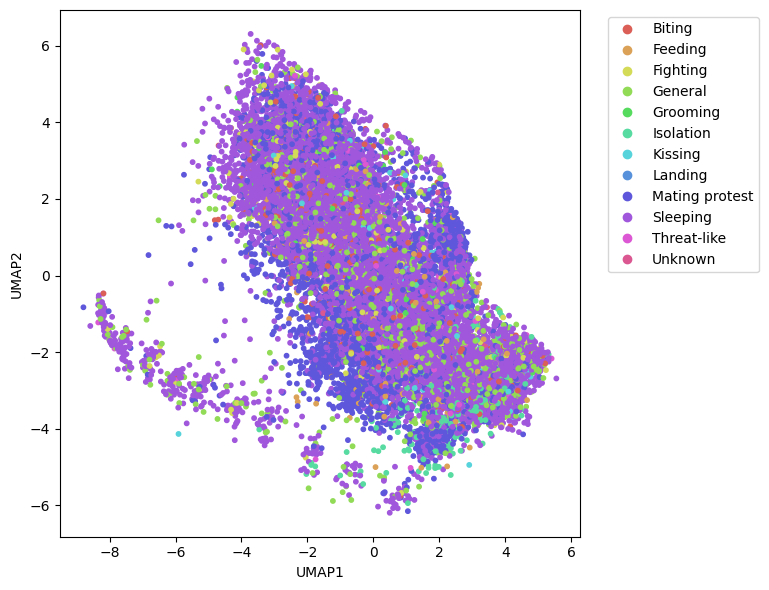

In [605]:
umap_2Dplot(ae_small_embedding[:,0] , ae_small_embedding[:,1] , y_train, mycolors = "hls", outname=None, showlegend=True)




In [552]:
test_st_pca.shape, test_data.reshape(test_st_pca.shape[0], -1).shape

((2896, 20), (2896, 1024))

In [610]:
LABELS.shape, hdbscan_labels.shape, y_train.shape

((13508,), (18034,), (18034,))

In [611]:
test_st_pca = st_scaler.fit_transform( test_pca )

#embedding = ae_embedder.embedding_
embedding = ae_small_embedder.encoder.predict(test_st_pca)
LABELS = np.array(test_labels).astype(int)
#embedding = pre_ae_embedder.embedding_

hdbscan_labels, hdbscan_clusterer = test_hdbscan(embedding)
hdb_nca_labels = test_nca(hdbscan_clusterer, embedding, n_neighbors  = 30 )
ms_labels, cluster_centers = test_mean_shift(embedding, quantile = 0.1 )

evaluate_hdbscan(LABELS, hdbscan_labels)

564/564 [==============================] - 1s 2ms/step


ValueError: invalid literal for int() with base 10: 'Mating protest'

/home/h21/luas6629/miniconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


ARI :0.007402922256404756, MI : 0.0951873314468367
Excluding noise - ARI :0.007402922256404756, MI : 0.0951873314468367
Assigned points: 0.33390883977900554
ARI :0.09000443953705592, MI : 0.24281787572907587
Excluding noise - ARI :0.09000443953705592, MI : 0.24281787572907587
Assigned points: 1.0
ARI :0.12165654608467401, MI : 0.2547635058957605
Excluding noise - ARI :0.12165654608467401, MI : 0.2547635058957605
Assigned points: 1.0


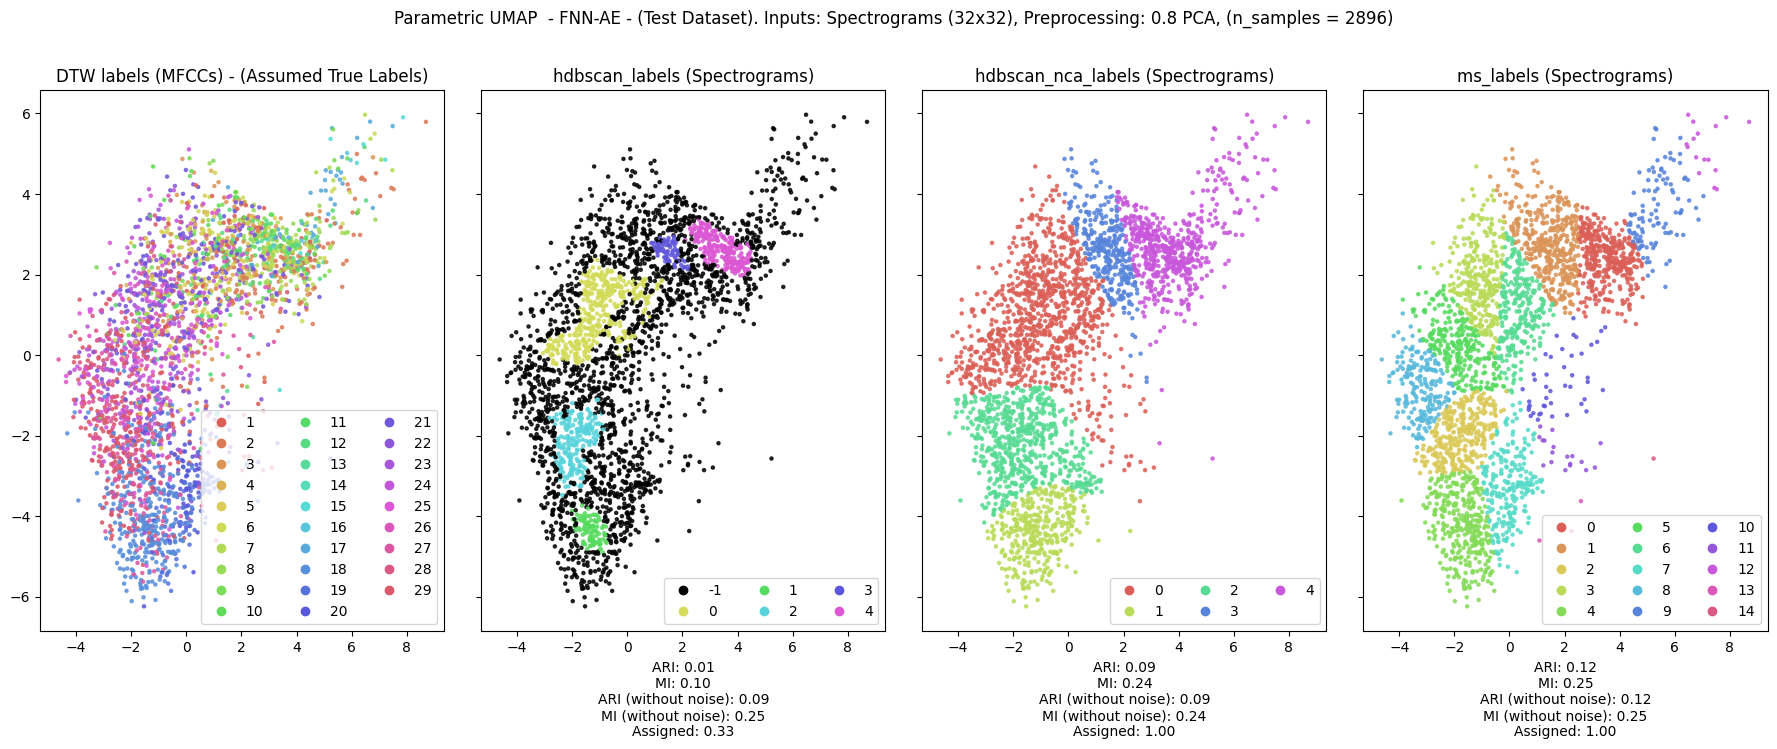

In [558]:
test_plot(embedding, 
          'Spectrograms (32x38)', 
          '0.8 PCA', 
          LABELS, 
          hdbscan_labels, 
          hdb_nca_labels, 
          ms_labels,
          color_set = 'hls',
          isParametric = True,
          title = ' - FNN-AE - (Train Dataset)' )


In [408]:
%%time
REDUCER = umap.UMAP(n_components=2, 
                    n_neighbors= 100,
                    metric = 'euclidean',  
                    repulsion_strength = 10,
                    #metric = calc_timeshift_pad,
                    min_dist = 0.0, 
                    random_state=0,
                    n_jobs = -1,

            

                    #local_connectivity = 1,
                    
                    #densmap=True,
                    #precomputed_knn=precomputed_knn
                    )

embedding_pca = REDUCER.fit_transform([t.ravel() for t in train_pca] )



CPU times: user 1min 57s, sys: 24.8 s, total: 2min 22s
Wall time: 31.8 s


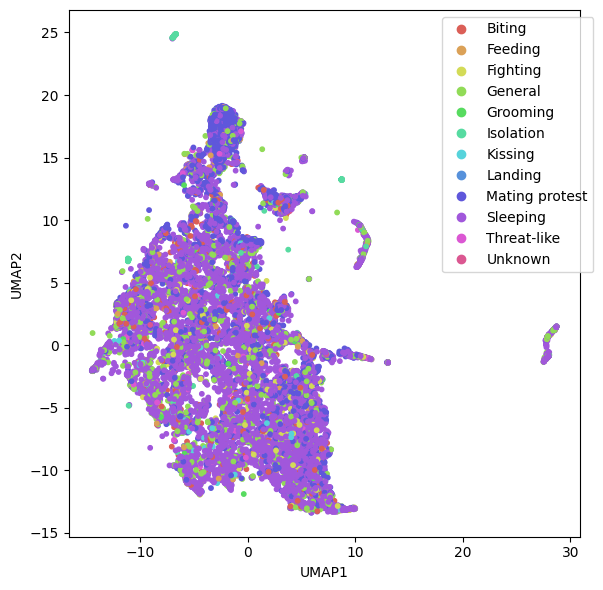

In [409]:
umap_2Dplot(embedding_pca[:,0], embedding_pca[:,1], y_train, mycolors = "hls", outname=None, showlegend=True)




## specs per bat

In [ ]:
test_specs = syllables_df.query(f'indv in {[str(215)]}').spectrogram
test_specs = np.stack( [scaler.fit_transform(t) for t in test_specs] )
test_specs.shape

In [627]:
#%%time
#bat_215_dtw = compute_dtw(test_specs)

Max time is 38
CPU times: user 4h 9min 3s, sys: 8.85 s, total: 4h 9min 12s
Wall time: 14min 20s


In [173]:
DS_FILENAME = 'bat_215'
DS_PROP = '32x38'

with open(f'{DS_FILENAME}_ds_{DS_PROP}.pkl','rb') as f:
    bat_215_dtw = pd.read_pickle(f)

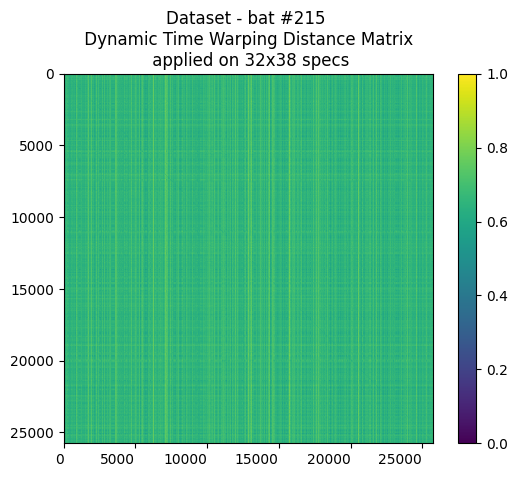

In [635]:
plot_dtw_matrix(norm_dendrogram(bat_215_dtw), 'Dataset - bat #215 \n', '\n applied on 32x38 specs')
                

In [174]:
Z = get_dendrogram(norm_dendrogram(bat_215_dtw), method='ward')
q_threshold = get_threshold(Z, elbow=False)
elbow_threshold = get_threshold(Z, elbow=True)

NameError: name 'get_dendrogram' is not defined

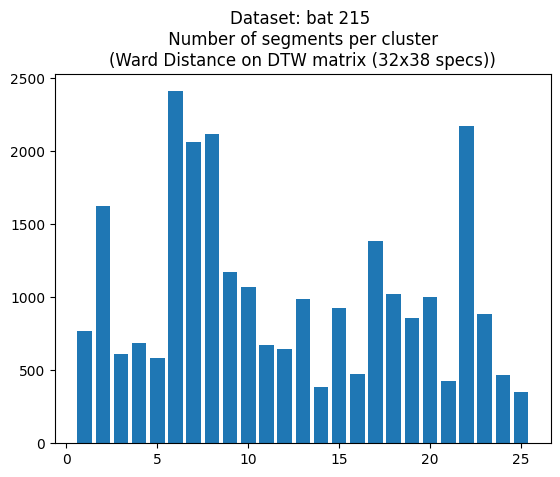

In [17]:
THRESHOLD = q_threshold


clusters_dendrogram = get_clusters(Z, THRESHOLD[0], criterion = 'distance')

plot_clusters_frequences(clusters_dendrogram, f"Dataset: {DS_FILENAME.replace('_', ' ')} \n", "\n(Ward Distance on DTW matrix (32x38 specs))")

In [643]:
clusters_dendrogram.shape

(25764,)

In [ ]:
## now let's reconstruct the sequences

In [20]:
bat_215 = syllables_df.query(f'indv in {[str(215)]}').copy()

In [21]:
bat_215['qt_ward'] = clusters_dendrogram

In [33]:
file_keys = list(map(lambda x : x.split('.')[0],  SEQUENCES.index.to_list() ))

In [34]:
tmp = bat_215.query(f'key in {file_keys}').groupby('key').apply(lambda x: x.sort_values("start_time")["qt_ward"].tolist()).copy()

tmp = tmp.reset_index()
tmp['key'] = tmp['key'].apply(lambda x : x + '.WAV')
tmp = tmp.set_index('key')

In [35]:
tmp[tmp.index.map(lambda x: x in SEQUENCES.index)];

In [36]:
SEQUENCES = SEQUENCES.drop( set(SEQUENCES.index) - set(tmp.index) )

In [37]:
SEQUENCES['qt_ward_all'] = tmp[0].values

In [38]:
SEQUENCES

qt_ward  \
File name                                                                   
121004165931143478.WAV                                           [13, 13]   
121004172433181482.WAV                                           [13, 13]   
121004172647137483.WAV                                               [13]   
121004172921179484.WAV                                       [13, 13, 13]   
121004173710156486.WAV                                               [13]   
...                                                                   ...   
140219054006223350.WAV  [21, 8, 22, 2, 27, 2, 20, 23, 2, 21, 27, 25, 1...   
140219054741046380.WAV  [27, 27, 20, 27, 27, 19, 29, 27, 2, 29, 2, 29,...   
140219055906489406.WAV                                     [25, 9, 21, 5]   
140219055915824409.WAV  [27, 27, 19, 2, 8, 17, 2, 8, 27, 22, 19, 26, 1...   
140219055925290410.WAV                         [26, 8, 27, 19, 8, 26, 26]   

                                                                  et_ward  \
File name                                                                   
121004165931143478.WAV                                         [201, 201]   
121004172433181482.WAV                                         [201, 201]   
121004172647137483.WAV                                              [199]   
121004172921179484.WAV                                    [199, 199, 199]   
121004173710156486.WAV                                              [201]   
...                                                                   ...   
140219054006223350.WAV  [308, 146, 318, 59, 370, 24, 285, 325, 20, 308...   
140219054741046380.WAV  [374, 368, 285, 366, 374, 275, 395, 374, 56, 3...   
140219055906489406.WAV                                [350, 158, 291, 91]   
140219055915824409.WAV  [373, 372, 272, 26, 143, 243, 44, 143, 372, 31...   
140219055925290410.WAV                [364, 136, 376, 276, 148, 362, 363]   

                                                                  hdbscan  \
File name                                                                   
121004165931143478.WAV                                           [-1, -1]   
121004172433181482.WAV                                           [-1, -1]   
121004172647137483.WAV                                               [-1]   
121004172921179484.WAV                                        [-1, -1, 2]   
121004173710156486.WAV                                                [1]   
...                                                                   ...   
140219054006223350.WAV  [-1, -1, 1, 1, -1, -1, -1, -1, 6, -1, -1, -1, ...   
140219054741046380.WAV  [-1, 1, -1, -1, 5, -1, -1, -1, 4, -1, 4, 3, 3,...   
140219055906489406.WAV                                   [-1, -1, -1, -1]   
140219055915824409.WAV  [-1, -1, 1, -1, -1, -1, -1, -1, 2, -1, 2, -1, ...   
140219055925290410.WAV                        [-1, -1, 2, -1, -1, -1, -1]   

                                                                  hdb_nca  \
File name                                                                   
121004165931143478.WAV                                             [1, 2]   
121004172433181482.WAV                                             [1, 1]   
121004172647137483.WAV                                                [2]   
121004172921179484.WAV                                          [1, 2, 2]   
121004173710156486.WAV                                                [1]   
...                                                                   ...   
140219054006223350.WAV  [5, 4, 1, 1, 4, 1, 4, 4, 6, 2, 3, 3, 2, 1, 2, ...   
140219054741046380.WAV  [3, 1, 3, 5, 5, 2, 5, 3, 4, 3, 4, 3, 3, 0, 5, ...   
140219055906489406.WAV                                       [3, 3, 5, 4]   
140219055915824409.WAV  [3, 3, 1, 4, 4, 4, 4, 4, 2, 3, 2, 4, 1, 3, 4, ...   
140219055925290410.WAV                              [3, 5, 2, 2, 4, 3, 3]   

                                                          

## All bats

In [ ]:
%%time

from dtaidistance import dtw_ndim

# all bats
all_bat_ids = list(str(i) for i in map(int, syllables_df.indv.unique()) if i > 200)

test_specs =  syllables_df.query(f'indv in {all_bat_ids}').spectrogram
test_specs = np.stack( [scaler.fit_transform(t) for t in test_specs] )
test_specs.shape

bat_all_dtw = compute_dtw(test_specs)

# save
DS_FILENAME = 'bat_ALL'
DS_PROP = '32x38'


with open(f'{DS_FILENAME}_ds_{DS_PROP}.pkl','wb') as f:
    pickle.dump(bat_all_dtw, f, protocol=pickle.HIGHEST_PROTOCOL)
    



Max time is 38


In [ ]:
%%time

# dendro
Z = get_dendrogram(norm_dendrogram(bat_all_dtw), method='ward')
q_threshold = get_threshold(Z, elbow=False)
elbow_threshold = get_threshold(Z, elbow=True)


# clusters
clusters_dendrogram = get_clusters(Z, THRESHOLD[0], criterion = 'distance')
plot_clusters_frequences(clusters_dendrogram, f"Dataset: {DS_FILENAME.replace('_', ' ')} \n", "\n(Ward Distance on DTW matrix (32x38 specs))")

In [ ]:
%%time

# syllables seq df
bat_all = syllables_df.query(f'indv in {all_bat_ids}')[['start_time','indv','indvi','context','key']].copy()
bat_all['qt_ward'] = clusters_dendrogram                                             
                                                        

DS_FILENAME = 'bat_ALL'
DS_PROP = '32x38'


with open(f'syllables_{DS_FILENAME}_from_{DS_PROP}.pkl','wb') as f:
    pickle.dump(bat_all, f, protocol=pickle.HIGHEST_PROTOCOL)


## 

## Test Autoencoder embdder with upscaled specs

In [648]:
#bat_215.groupby('key').apply(lambda x :

In [587]:
test_data = syllables_df.sample(frac = 0.1)
test_specs = np.stack(t for t in test_data.spectrogram.values)
test_labels = np.stack(t for t in test_data.context.values)

/home/h21/luas6629/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [588]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
test_specs = np.stack( [scaler.fit_transform(t) for t in test_specs] )

In [575]:
from skimage.transform import resize

def upscale_spec(spec, size = (128, 128)):

    #spec = calc_zscore(spec)
    
    upscaled_spec = resize(spec, size, mode='constant')
    
    return upscaled_spec


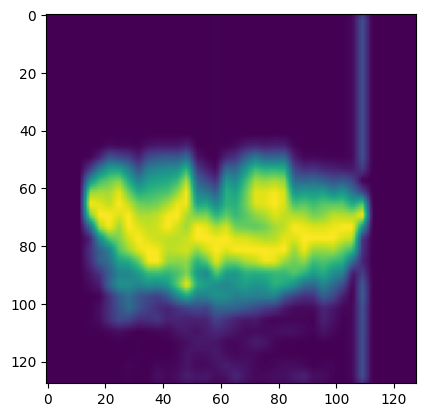

In [576]:
plt.imshow( upscale_spec(test_specs[0]) )

In [585]:
%%time

from joblib import Parallel, delayed
from tqdm import tqdm



test_specs = Parallel(n_jobs=-1, verbose=2)(delayed(

    upscale_spec

)(spec, size = (128, 128)) for batch in tqdm(group_list(test_specs, 50)) for spec in batch);

test_specs = np.array(test_specs)


0it [00:00, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.

4it [00:00, 32.18it/s][Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.2s

9it [00:00, 39.44it/s]
20it [00:00, 55.51it/s]
40it [00:00, 84.71it/s]
61it [00:00, 113.56it/s][Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed:    0.8s

81it [00:00, 117.73it/s]
102it [00:01, 110.87it/s]
122it [00:01, 97.53it/s] 
143it [00:01, 94.55it/s]
163it [00:01, 81.89it/s]
184it [00:02, 73.74it/s]
204it [00:02, 70.81it/s]
224it [00:02, 70.51it/s]
245it [00:03, 65.85it/s][Parallel(n_jobs=-1)]: Done 10432 tasks      | elapsed:    3.2s

265it [00:03, 65.19it/s]
286it [00:03, 67.43it/s]
306it [00:04, 67.01it/s]
327it [00:04, 69.35it/s]
347it [00:04, 69.85it/s]
368it [00:04, 71.25it/s]
388it [00:05, 72.61it/s]
409it [00:05, 77.96it/s]
429it [00:05, 78.53it/s]
450it [00:05, 79.80it/s]
470it [00:06, 78.19it/s][Parallel(n_jobs=-1)]: Done 22112 tasks      | elapsed:    6.3s

491it [00:06, 77.81it/s]
511i

CPU times: user 8.44 s, sys: 6.93 s, total: 15.4 s
Wall time: 15.4 s


1394/1394 [==============================] - 6s 4ms/step


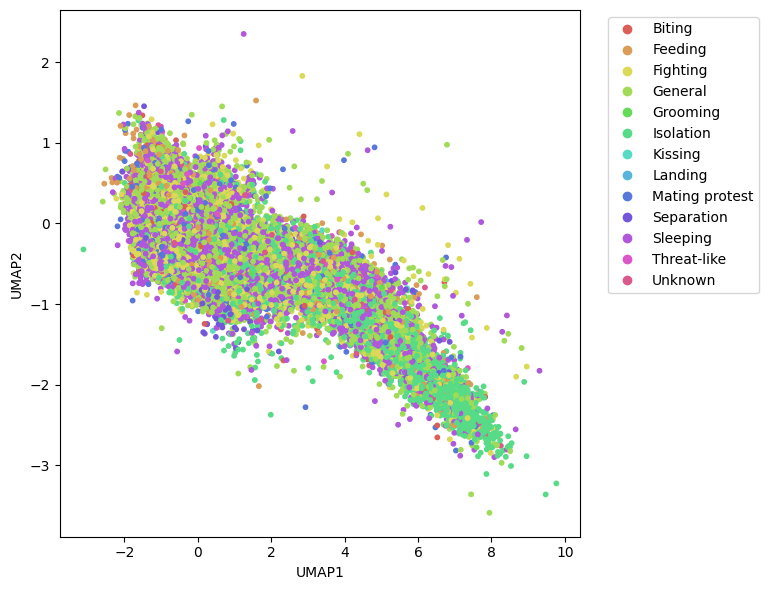

In [586]:
#embedding = ae_embedder.embedding_
embedding = ae_embedder.encoder.predict(test_specs.reshape(test_specs.shape[0], 128, 128, 1))

umap_2Dplot(embedding[:,0],embedding[:,1], test_labels, 'hls', outname=None, showlegend=True)

In [685]:
%%time
REDUCER = umap.UMAP(n_components=2, 
                    n_neighbors= 100,
                    metric = 'euclidean', 
                    repulsion_strength = 10,
                    #metric = calc_timeshift_pad,
                    min_dist = 0.0, 
                    random_state=0,
                    n_jobs = -1,

            

                    #local_connectivity = 1,
                    
                    #densmap=True,
                    #precomputed_knn=precomputed_knn
                    )


embedding_small = REDUCER.fit_transform([t.ravel() for t in test_specs] )

CPU times: user 5min 31s, sys: 44.8 s, total: 6min 16s
Wall time: 52.9 s


In [653]:
test_labels = bat_215['qt_ward']

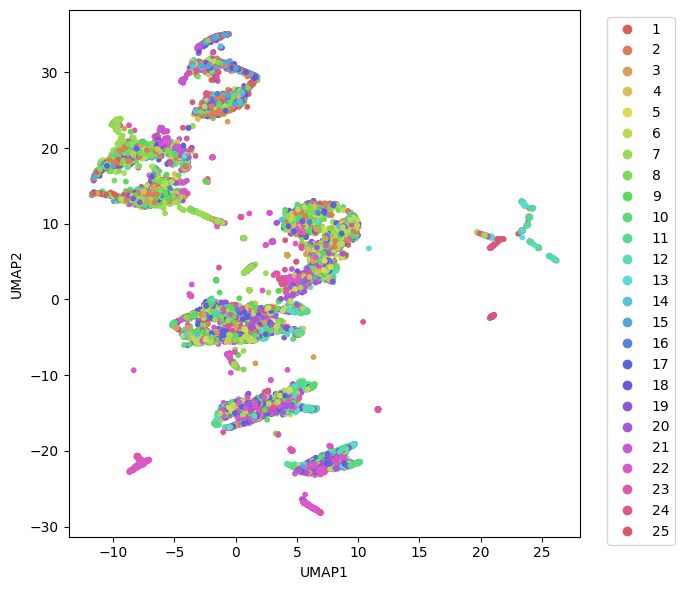

In [686]:
umap_2Dplot(embedding_small[:,0],embedding_small[:,1], test_labels, 'hls', outname=None, showlegend=True)

In [407]:
%%time
REDUCER = umap.UMAP(n_components=2, 
                    n_neighbors= 100,
                    metric = 'precomputed',  
                    repulsion_strength = 10,
                    #metric = calc_timeshift_pad,
                    min_dist = 0.0, 
                    random_state=0,
                    n_jobs = -1,

            

                    #local_connectivity = 1,
                    
                    #densmap=True,
                    #precomputed_knn=precomputed_knn
                    )


embedding_small_dtw = REDUCER.fit_transform(bat_215_dtw )

CPU times: user 68 µs, sys: 5 µs, total: 73 µs
Wall time: 84.4 µs


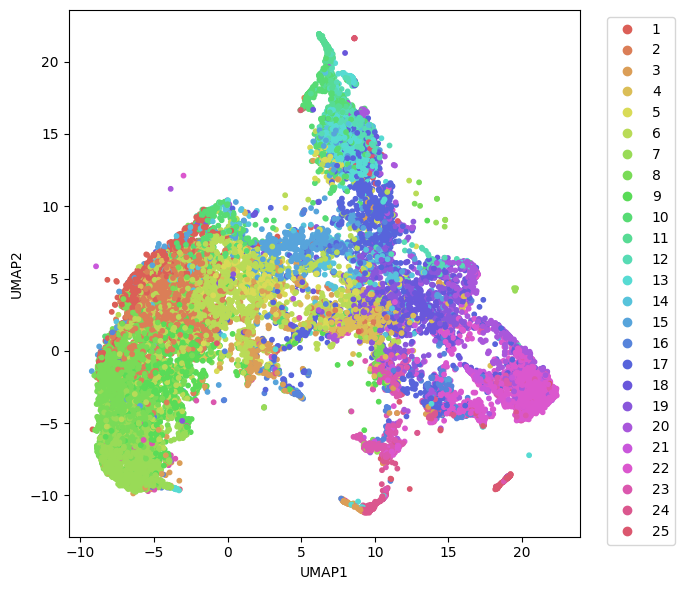

In [688]:
umap_2Dplot(embedding_small_dtw[:,0],embedding_small_dtw[:,1], test_labels, 'hls', outname=None, showlegend=True)

In [689]:
embedding_combined = embedding_small_dtw + embedding_small



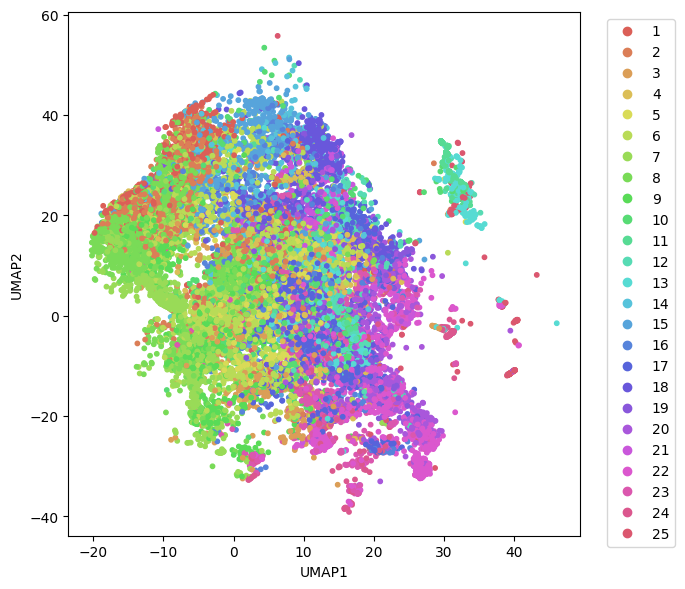

In [690]:
umap_2Dplot(embedding_combined[:,0],embedding_combined[:,1], test_labels, 'hls', outname=None, showlegend=True)

## Attention sequences

In [52]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


context_dict = {
    0:'Unknown',
    1:'Separation',
    2:'Biting',
    3:'Feeding',
    4:'Fighting',
    5:'Grooming',
    6:'Isolation',
    7:'Kissing',
    8:'Landing',
    9:'Mating protest',
    10:'Threat-like',
    11:'General',
    12:'Sleeping',
}

context_dict_id = {v : k for k, v in context_dict.items()}

### Using Sequences from original segments

In [332]:
SEQUENCES.head(1)

NameError: name 'SEQUENCES' is not defined

In [515]:
#sample_SEQ = SEQUENCES.query(f'context in {[3, 4, 5, 6, 7]} and length <= {20}').groupby('context').sample(frac=1.)
sample_SEQ = SEQUENCES.query(f'context in {[3, 4, 5, 6, 7]}').groupby('context').sample(frac=1.)

In [516]:
SEQUENCES.groupby('context').size()

context
2      292
3       96
4       50
5       48
6       75
7       48
8        1
9      629
10      46
11     627
12    4162
dtype: int64

In [809]:
SEQUENCES['qt_ward_all'].apply(len).describe()

count    6071.000000
mean        4.230440
std         5.728374
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       162.000000
Name: qt_ward_all, dtype: float64

In [517]:
sample_SEQ.groupby('context').size()

context
3    96
4    50
5    48
6    75
7    48
dtype: int64

In [518]:
X = sample_SEQ['hdb_nca']
y = sample_SEQ['context'] - 3
#.apply(lambda x : 0 if ( x -2 ) == 0 else 1) 

In [519]:
X, y

(File name
 130419215531925873.WAV                                       [10]
 140215185031532450.WAV                           [8, 4, 8, 13, 9]
 130510034013433692.WAV                                        [9]
 130528034046357708.WAV                                [11, 13, 4]
 140216002401226250.WAV                                       [11]
                                            ...                   
 130502060017851221.WAV    [8, 9, 14, 8, 9, 4, 8, 3, 12, 7, 5, 12]
 130304073415365906.WAV                                   [12, 12]
 130228032829523771.WAV                                    [10, 5]
 130305020334264116.WAV                                       [10]
 130214052835985372.WAV                                    [11, 0]
 Name: hdb_nca, Length: 317, dtype: object,
 File name
 130419215531925873.WAV    0
 140215185031532450.WAV    0
 130510034013433692.WAV    0
 130528034046357708.WAV    0
 140216002401226250.WAV    0
                          ..
 130502060017851221.WAV

In [524]:
# Padding sequences
X = pad_sequences(X, padding='post')

In [525]:
# Splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert lists to numpy arrays for the model
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [526]:
#np.concatenate(X).ravel()
np.unique(X), np.unique(y)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=int32),
 array([0, 1, 2, 3, 4]))

### Using Sequences from Dynamic Thresholded Segments

In [219]:
specs_syllables_df['duration'] = specs_syllables_df['end_time'] - specs_syllables_df['start_time'] 

In [311]:
#import from TF-AE
ALL_SEQUENCES = pd.DataFrame()

ALL_SEQUENCES['seq_hdbscan'] = specs_syllables_df.groupby('key').apply(lambda x: x.sort_values(by = 'start_time')['hdbscan_labels'].to_list())
ALL_SEQUENCES['seq_ms'] = specs_syllables_df.groupby('key').apply(lambda x: x.sort_values(by = 'start_time')['ms_labels'].to_list())
ALL_SEQUENCES['context'] = specs_syllables_df.groupby('key').apply(lambda x: x.sort_values(by = 'start_time')['context'].to_list()).apply(lambda x : np.unique(x)[0])
ALL_SEQUENCES['durations'] = specs_syllables_df.groupby('key').apply(lambda x: x.sort_values(by = 'start_time')['duration'].to_list())

In [312]:
ALL_SEQUENCES['context_label'] = ALL_SEQUENCES['context']
ALL_SEQUENCES['context'] = ALL_SEQUENCES['context'].apply(lambda x : context_dict_id[x])

In [221]:
ALL_SEQUENCES.groupby('context').sample(n=2)

seq_hdbscan  \
key                                                                  
130316092724183832                     [0, 5, 0, 0, 3, 0, 3, 5, 5]   
130416112843197582                                    [3, 1, 1, 0]   
130307203110961582                                          [5, 5]   
130124195512679959                                             [5]   
121129042039662507                                          [4, 4]   
130524183651702364               [5, 0, 0, 0, 3, 3, 0, 0, 5, 0, 0]   
130115021113504426                                             [3]   
130119044331323297                                          [2, 5]   
121220013044995192                    [-1, 7, 0, 7, -1, 7, -1, -1]   
121126020137316948                                   [-1, 7, 7, 7]   
130530011638289257                                             [3]   
130117050629390868                                          [5, 5]   
140216195131547888                                             [5]   
130203201417932784                                 [3, 5, 5, 0, 0]   
120705054348776790  [4, 4, 0, 4, 0, 4, 4, 4, 4, 0, 4, 0, -1, 0, 0]   
130419192235227426                                             [3]   
120623042832174166                  [0, 0, 5, 5, 4, 4, 4, 5, 4, 5]   
120623213309371932                             [7, -1, -1, -1, -1]   
130308233959240802                                             [0]   
121009221404739615                  [2, 1, 2, 0, 5, 5, 5, 0, 5, 5]   

                                                           seq_ms  \
key                                                                 
130316092724183832                    [0, 1, 0, 0, 2, 0, 2, 1, 1]   
130416112843197582                                   [2, 6, 6, 0]   
130307203110961582                                         [1, 1]   
130124195512679959                                            [1]   
121129042039662507                                         [7, 7]   
130524183651702364              [1, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0]   
130115021113504426                                            [2]   
130119044331323297                                         [3, 1]   
121220013044995192                       [4, 4, 0, 4, 4, 4, 4, 4]   
121126020137316948                                   [4, 4, 4, 4]   
130530011638289257                                            [2]   
130117050629390868                                         [1, 1]   
140216195131547888                                            [1]   
130203201417932784                                [2, 1, 1, 0, 0]   
120705054348776790  [7, 7, 8, 7, 8, 7, 7, 7, 7, 8, 7, 8, 4, 8, 8]   
130419192235227426                                            [2]   
120623042832174166                 [8, 0, 1, 1, 7, 7, 7, 1, 7, 1]   
120623213309371932                                [4, 5, 5, 5, 5]   
130308233959240802                                            [0]   
121009221404739615                 [3, 6, 3, 0, 1, 1, 1, 0, 1, 1]   

                           context  \
key                                  
130316092724183832          Biting   
130416112843197582          Biting   
130307203110961582         Feeding   
130124195512679959         Feeding   
121129042039662507        Fighting   
130524183651702364        Fighting   
130115021113504426        Grooming   
130119044331323297        Grooming   
121220013044995192       Isolation   
121126020137316948       Isolation   
130530011638289257         Kissing   
130117050629390868         Kissing   
140216195131547888         Landing   
130203201417932784         Landing   
120705054348776790  Mating protest   
130419192235227426  Mating protest   
120623042832174166      Separation   
120623213309371932      Separation   
130308233959240802     Threat-like   
121009221404739615     Threat-like   

                                                            durations  
key                                                                    
13031609272418

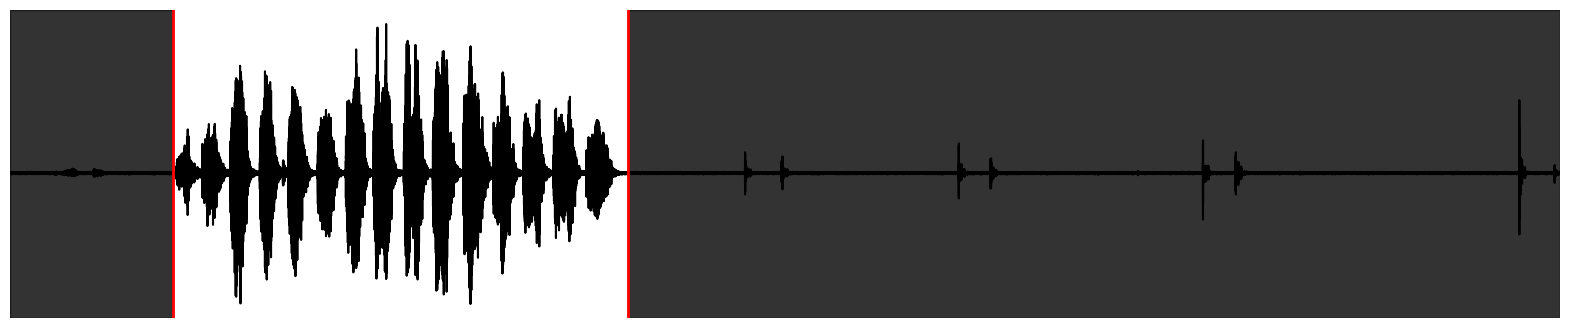

In [74]:
plot_and_play_wav('120603154340013745.WAV')

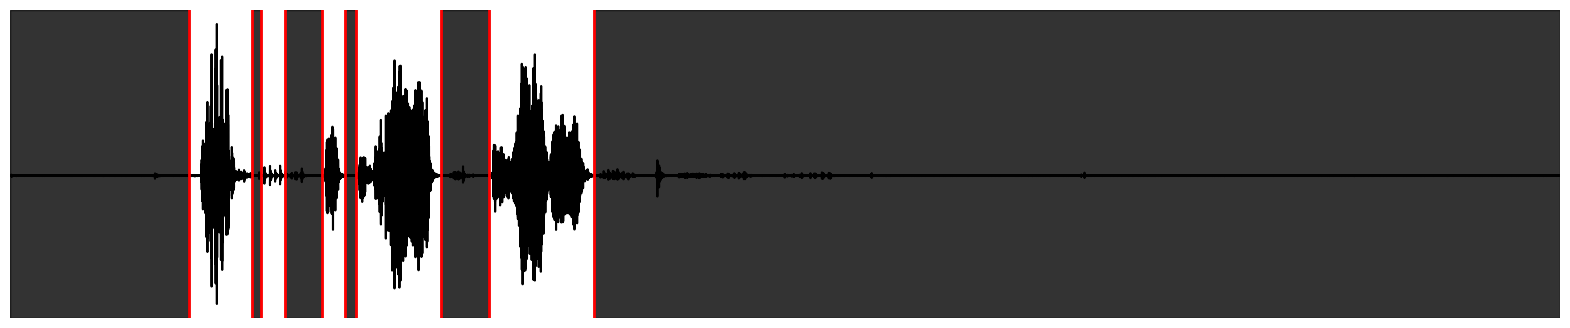

In [75]:
plot_and_play_wav('120602190130776471.WAV')

In [46]:
ALL_SEQUENCES['seq_hdbscan'].apply(len).describe()

count    25910.000000
mean         5.888769
std          6.665180
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        157.000000
Name: seq_hdbscan, dtype: float64

In [167]:
ALL_SEQUENCES['length'] = ALL_SEQUENCES['seq_hdbscan'].apply(lambda x : len(x))

# Calculate IQR
Q1 = np.percentile(ALL_SEQUENCES['length'].values, 25)
Q3 = np.percentile(ALL_SEQUENCES['length'].values, 75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [843]:
def get_outlier_threshold (df, alphabeth):
    lengths = df[ alphabeth ].apply(lambda x : len(x)).values
    # Calculate IQR
    Q1 = np.percentile(lengths, 25)
    Q3 = np.percentile(lengths, 75)
    IQR = Q3 - Q1

    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return round(lower_bound), round(upper_bound)

In [813]:
get_outlier_threshold (ALL_SEQUENCES, 'seq_hdbscan')

(-5.5, 14.5)

In [168]:
cond = ALL_SEQUENCES['length'].apply(lambda x : x <= upper_bound)

In [310]:
X = ALL_SEQUENCES[cond]['seq_hdbscan'].apply(lambda x :  [ i + 1 for i in x] ).values # add 1 to make noise class 0 and ignore in tranform
y = ALL_SEQUENCES[cond]['context'].apply(lambda x : context_dict_id[x] -1 ).values # minus 1 to get labels starts from 0

KeyError: 9

In [170]:
# Padding sequences
X = pad_sequences(X, padding='post')
X.shape

(23960, 14)

In [171]:
# Splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify =y, test_size=0.2, random_state=42)

# Convert lists to numpy arrays for the model
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [172]:
#np.concatenate(X).ravel()
np.unique(X), np.unique(y)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [110]:
num_categories_input

9

In [114]:
X.shape

(25910, 157)

### Classifier

In [111]:
class MyMultiHeadAttention(tf.keras.layers.MultiHeadAttention):
    def __init__(self, *args, **kwargs):
        super(MyMultiHeadAttention, self).__init__(*args, **kwargs) # Add this line
        self.attention_scores = None

    def call(self, inputs, **kwargs):
        output, attention_scores = super(MyMultiHeadAttention, self).call(inputs, **kwargs)
        self.attention_scores = attention_scores
        return output


In [210]:
import tensorflow as tf
from tensorflow.keras import layers

# Number of categories for input and output
num_categories_input = len(np.unique(X))
num_categories_output = len(np.unique(y))

# Hyperparameters
d_model = 256  # dimension of the embedding space
num_heads = 16  # number of attention heads
ff_dim = 512  # dimension of feedforward network
maxlen = 6  # maximum expected sequence length

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(d_model)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, d_model):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=d_model)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=d_model)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

inputs = tf.keras.layers.Input(shape=(None,))  # Input is a sequence of categorical IDs
embedding_layer = TokenAndPositionEmbedding(maxlen, num_categories_input, d_model)  # 50 is the maximum expected sequence length
x = embedding_layer(inputs)
transformer_block = TransformerBlock(d_model, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(num_categories_output, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), 
              metrics=['accuracy'])

In [137]:
inputs.shape

TensorShape([None, None])

In [211]:
from sklearn.utils import class_weight

# try mitigate imbalanced classes

classes = np.unique(y_train)

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)

In [212]:
class_weights = dict(zip(np.unique(y_train), class_weights))

In [213]:
# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test), class_weight=class_weights)

Epoch 1/10
300/300 [==============================] - 8s 18ms/step - loss: 2.3105 - accuracy: 0.0694 - val_loss: 2.2976 - val_accuracy: 0.0336
Epoch 2/10
300/300 [==============================] - 5s 17ms/step - loss: 2.2921 - accuracy: 0.1458 - val_loss: 2.2902 - val_accuracy: 0.2218
Epoch 3/10
300/300 [==============================] - 5s 16ms/step - loss: 2.2805 - accuracy: 0.2284 - val_loss: 2.2411 - val_accuracy: 0.3393
Epoch 4/10
300/300 [==============================] - 5s 16ms/step - loss: 2.2769 - accuracy: 0.1896 - val_loss: 2.2618 - val_accuracy: 0.0883
Epoch 5/10
300/300 [==============================] - 5s 16ms/step - loss: 2.2517 - accuracy: 0.2041 - val_loss: 2.2599 - val_accuracy: 0.1434
Epoch 6/10
300/300 [==============================] - 5s 16ms/step - loss: 2.2551 - accuracy: 0.1127 - val_loss: 2.2389 - val_accuracy: 0.1528
Epoch 7/10
300/300 [==============================] - 5s 16ms/step - loss: 2.2511 - accuracy: 0.1160 - val_loss: 2.2218 - val_accuracy: 0.1763

In [214]:
y_pred = model.predict(X_test[:])
y_pred_classes = np.argmax(y_pred, axis=1)
conf_matrix = tf.math.confusion_matrix(labels=y_test,
                                       predictions=y_pred_classes)


150/150 [==============================] - 1s 5ms/step


In [215]:
conf_matrix

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 59,  17,   0,   6,   0,   3,   0,   1,   0,   0],
       [ 22, 182,   0,  68,   0,   0,   0,  14,  34,  14],
       [185, 740,   0, 154,   0,   5,   0,  25, 151,  43],
       [146, 300,   0, 507,   0,   3,   0,  40, 192, 139],
       [  6,  34,   0,  12,   0,   0,   0,   5,  12,   4],
       [ 37, 436,   0, 409,   0, 118,   0,   3,  18,   6],
       [  8,  48,   0,   3,   0,   0,   0,   2,   9,   0],
       [  0,   3,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 42, 129,   0,  98,   0,   0,   0,   8,  89,  21],
       [ 19,  55,   0,  54,   0,   1,   0,   9,  23,  21]], dtype=int32)>

In [216]:
y_test

array([5, 3, 2, ..., 8, 5, 2])

In [124]:
y_pred_classes

array([3, 3, 3, ..., 2, 3, 3])

In [125]:
y

key
120601002132055008    8
120601044742952687    2
120601063000749337    3
120601121832923352    5
120602185932558467    2
                     ..
140219055915824409    8
140219055925290410    8
140219102444234429    3
140219102458100432    3
140219120336957438    8
Name: context, Length: 25910, dtype: int64

### Other classifier, simpler ?

In [222]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=num_categories_input, output_dim=d_model))
model.add(tf.keras.layers.LSTM(units=128, return_sequences=True))
model.add(tf.keras.layers.LSTM(units=64))
model.add(tf.keras.layers.Dense(num_categories_output, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=['accuracy'])


2023-07-05 17:57:32.024451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 17:57:32.025829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 17:57:32.027216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [223]:
# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test), class_weight=class_weights)

Epoch 1/10


2023-07-05 17:57:51.707709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 17:57:51.709587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 17:57:51.710847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

299/300 [============================>.] - ETA: 0s - loss: 2.0790 - accuracy: 0.2610

2023-07-05 17:57:59.661087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 17:57:59.662778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 17:57:59.664039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

300/300 [==============================] - 9s 17ms/step - loss: 2.0777 - accuracy: 0.2610 - val_loss: 1.8605 - val_accuracy: 0.2836
Epoch 2/10
300/300 [==============================] - 4s 12ms/step - loss: 1.9846 - accuracy: 0.2970 - val_loss: 1.8011 - val_accuracy: 0.3491
Epoch 3/10
300/300 [==============================] - 4s 12ms/step - loss: 1.9436 - accuracy: 0.3087 - val_loss: 1.8823 - val_accuracy: 0.3230
Epoch 4/10
300/300 [==============================] - 4s 12ms/step - loss: 1.9278 - accuracy: 0.3294 - val_loss: 1.8030 - val_accuracy: 0.3232
Epoch 5/10
300/300 [==============================] - 4s 12ms/step - loss: 1.8914 - accuracy: 0.3139 - val_loss: 1.7464 - val_accuracy: 0.3270
Epoch 6/10
300/300 [==============================] - 4s 13ms/step - loss: 1.8876 - accuracy: 0.3213 - val_loss: 1.7709 - val_accuracy: 0.3170
Epoch 7/10
300/300 [==============================] - 4s 12ms/step - loss: 1.8975 - accuracy: 0.2920 - val_loss: 1.8161 - val_accuracy: 0.3095
Epoch 8/10

In [224]:
y_pred = model.predict(X_test[:])
y_pred_classes = np.argmax(y_pred, axis=1)
conf_matrix = tf.math.confusion_matrix(labels=y_test,
                                       predictions=y_pred_classes)
conf_matrix

2023-07-05 17:58:37.138881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 17:58:37.142553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 17:58:37.145024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

150/150 [==============================] - 2s 4ms/step


<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 65,   0,   1,   4,   0,   6,   2,   7,   1,   0],
       [ 15,   0,  10,  57,   0,   2,  89,  97,  45,  19],
       [153,   0,  91, 163,   0,  13, 320, 375, 141,  47],
       [119,   0,  28, 489,   0,  20,  99, 188, 254, 130],
       [  3,   0,   3,  11,   0,   0,  16,  24,  11,   5],
       [ 56,   0,  19,  12,   0, 854,  47,  23,  11,   5],
       [  5,   0,   3,   2,   0,   0,  30,  21,   8,   1],
       [  0,   0,   0,   0,   0,   0,   1,   2,   0,   0],
       [ 29,   0,   8,  82,   0,   2,  48, 101, 100,  17],
       [ 16,   0,  12,  56,   1,   2,  17,  29,  23,  26]], dtype=int32)>

## HMM ??

In [411]:
X = ALL_SEQUENCES['seq_hdbscan'].apply(lambda x :  [ i for i in x] ).values
y = ALL_SEQUENCES['context'].values

In [341]:
X = SEQUENCES['qt_ward'].values
y = SEQUENCES['context'].values

In [412]:
from sklearn.feature_extraction.text import CountVectorizer

# Create the CountVectorizer object
vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)

# Fit the vectorizer and transform the data
X_bow = vectorizer.fit_transform(X)

/home/h21/luas6629/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [343]:
print(X_bow.toarray()[2])

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [344]:
from hmmlearn import hmm
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_bow.toarray(), y, test_size=0.25, random_state=42)

# Initialize a list to store the HMMs
hmms = []

# Train a separate HMM for each class
for i in np.unique(y_train):
    # Select the sequences belonging to this class
    X_train_i = X_train[y_train == i]

    # Create and train the HMM
    model = hmm.GaussianHMM(n_components=1)
    model.fit(X_train_i)
    hmms.append(model)

In [345]:
from sklearn.metrics import accuracy_score

# Initialize an array to store the predictions
y_pred = np.zeros(len(y_test))

# Classify each test sequence
for i in range(len(y_test)):
    # Calculate the log likelihood of the sequence for each HMM
    log_likelihoods = [model.score(X_test[i].reshape(1, -1)) for model in hmms]

    # The predicted class is the one for which the HMM has the highest log likelihood
    y_pred[i] = np.argmax(log_likelihoods)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.009874917709019092


In [346]:
log_likelihoods

[13.82441693120921,
 16.812921551204738,
 -18.458831344365905,
 26.5423766553638,
 -2740.6181804541593,
 16.785800154660528,
 2.5020361710784567,
 16.849161337876723,
 8.26943255476744,
 8.385014761615047]

In [347]:
y_pred[:10]

array([7., 7., 2., 3., 7., 8., 2., 4., 9., 3.])

In [348]:
y_test[:10]

array([12,  9, 12, 12,  2, 12, 12, 12, 12, 12])

### Stats 

(array([1.8333e+04, 4.4160e+03, 1.7260e+03, 7.1900e+02, 2.9900e+02,
        1.8100e+02, 8.1000e+01, 5.4000e+01, 2.7000e+01, 1.2000e+01,
        2.2000e+01, 9.0000e+00, 4.0000e+00, 3.0000e+00, 5.0000e+00,
        8.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1. ,   6.2,  11.4,  16.6,  21.8,  27. ,  32.2,  37.4,  42.6,
         47.8,  53. ,  58.2,  63.4,  68.6,  73.8,  79. ,  84.2,  89.4,
         94.6,  99.8, 105. , 110.2, 115.4, 120.6, 125.8, 131. , 136.2,
        141.4, 146.6, 151.8, 157. ]),
 <BarContainer object of 30 artists>)

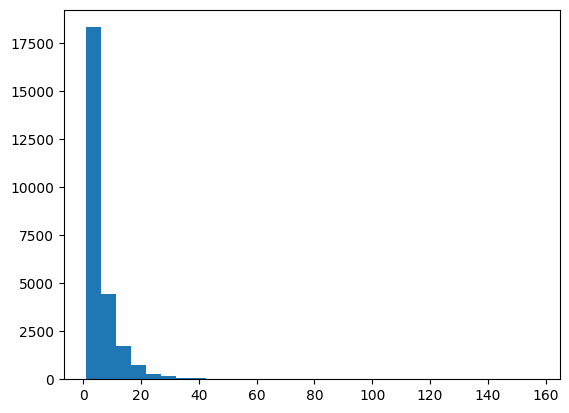

In [591]:
plt.hist(ALL_SEQUENCES['seq_hdbscan'].apply(len), bins = 30)

In [592]:
ALL_SEQUENCES['seq_hdbscan'].apply(len).describe()

count    25910.000000
mean         5.888769
std          6.665180
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        157.000000
Name: seq_hdbscan, dtype: float64

In [511]:
states = np.unique(sorted(y_train))
id2topic = dict(zip(range(len(states)), states))

In [441]:
id2topic

{0: 'Biting',
 1: 'Feeding',
 2: 'Fighting',
 3: 'Grooming',
 4: 'Isolation',
 5: 'Kissing',
 6: 'Landing',
 7: 'Mating protest',
 8: 'Separation',
 9: 'Threat-like'}

In [512]:
start_probs = np.array([0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [385]:
ALL_SEQUENCES.explode('seq_hdbscan').groupby('context_label').size()

context_label
Biting             6307
Feeding           21528
Fighting          58329
Grooming           1534
Isolation         36231
Kissing            1042
Landing              39
Mating protest    18417
Separation         2931
Threat-like        6220
dtype: int64

<Figure size 1500x800 with 0 Axes>

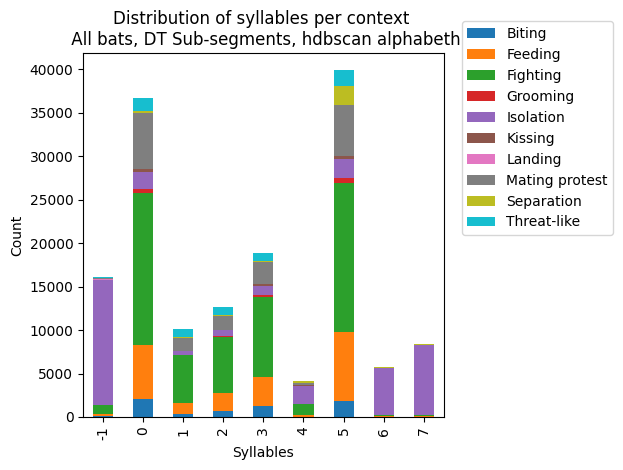

In [878]:
def plot_syllables_per_context(df, alphabeth_col, context_col, title = ''):
    
    # Convert the groupby results to a DataFrame and reset index
    tmp = df.explode( alphabeth_col ).groupby([ alphabeth_col , context_col ]).size().reset_index()
    tmp.columns = [ alphabeth_col , context_col , 'count']

    # Pivot the DataFrame
    df_pivot = tmp.pivot(index= alphabeth_col , columns= context_col , values='count').fillna(0)

    # Plot
    plt.figure(figsize=(15,8))
    df_pivot.plot(kind='bar', stacked=True)
    plt.title(f'Distribution of syllables per context {title }')
    plt.xlabel('Syllables')
    plt.ylabel('Count')
    plt.legend(loc=(1.05, 0.5))
    plt.tight_layout()
    plt.show()

plot_syllables_per_context(ALL_SEQUENCES, 'seq_hdbscan', 'context_label', '\n All bats, DT Sub-segments, hdbscan alphabeth')

<Figure size 1500x800 with 0 Axes>

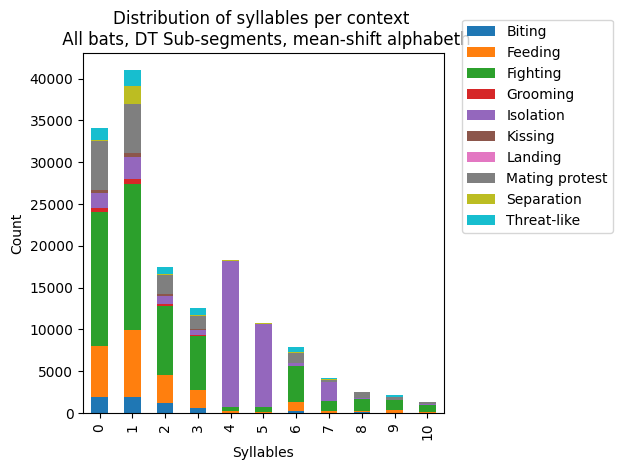

In [879]:
plot_syllables_per_context(ALL_SEQUENCES, 'seq_ms', 'context_label', '\n All bats, DT Sub-segments, mean-shift alphabeth')

In [871]:
SEQUENCES['context_label'] = SEQUENCES['context'].apply(lambda x : context_dict[x])

<Figure size 1500x800 with 0 Axes>

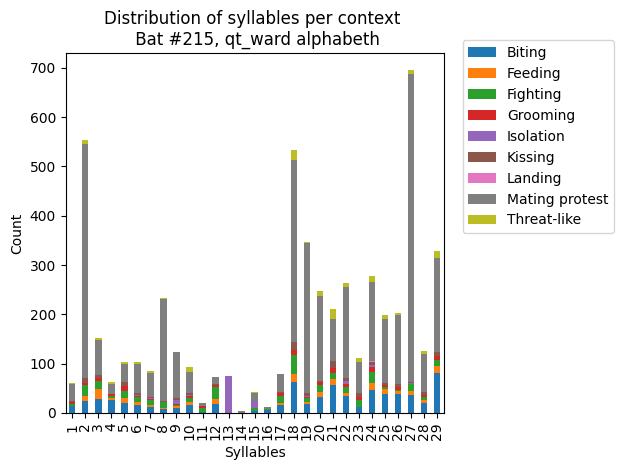

<Figure size 1500x800 with 0 Axes>

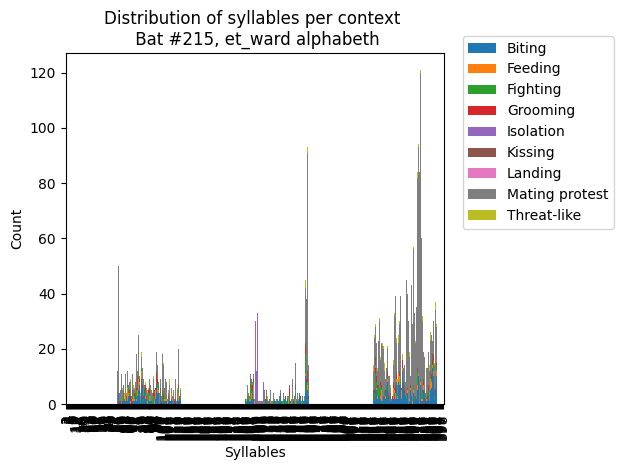

<Figure size 1500x800 with 0 Axes>

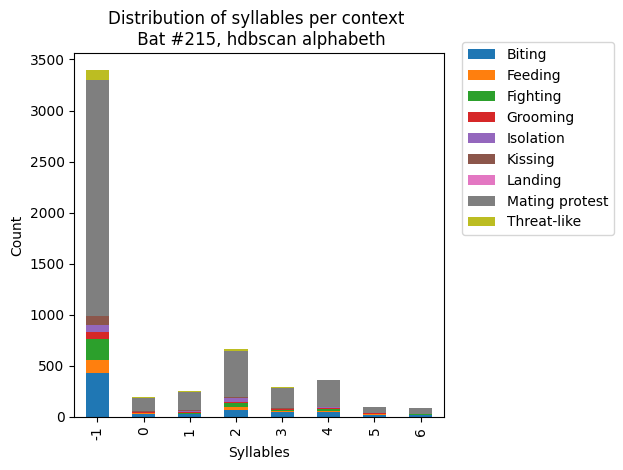

<Figure size 1500x800 with 0 Axes>

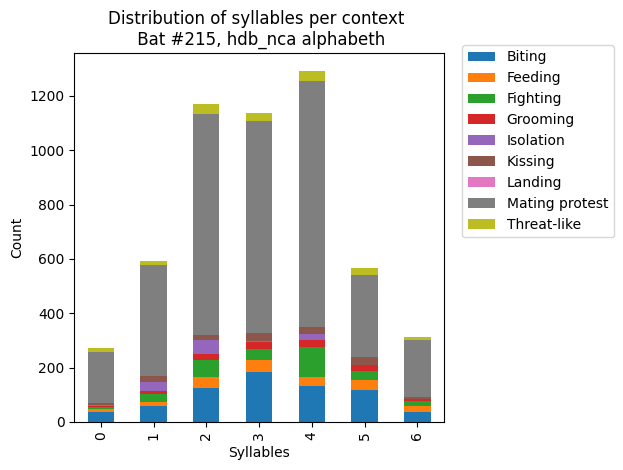

<Figure size 1500x800 with 0 Axes>

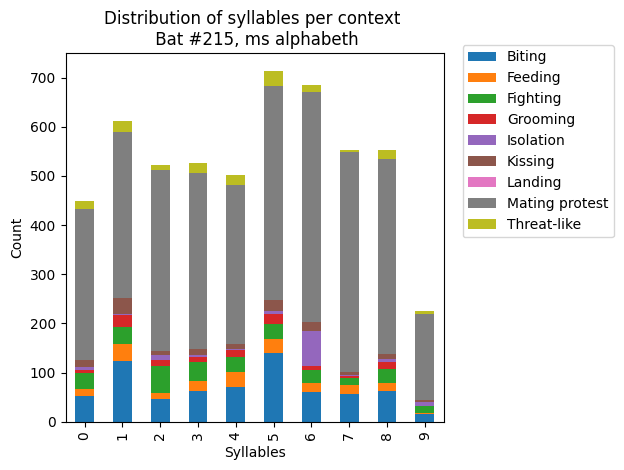

In [877]:
for alphabeth in ['qt_ward', 'et_ward', 'hdbscan', 'hdb_nca', 'ms']:
    removed_contexts = ['Unknown', 'General', 'Sleeping']
    plot_syllables_per_context(SEQUENCES.query(f'context_label not in {removed_contexts}'), alphabeth, 'context_label', f'\n Bat #215, {alphabeth} alphabeth')
    

### Multiclass? 

In [844]:
ALPHABETH = 'qt_ward'
SEQ_DF = SEQUENCES

In [845]:
lower_bound, upper_bound = get_outlier_threshold (SEQ_DF, ALPHABETH)
cond = SEQ_DF[ ALPHABETH ].apply(lambda x : 2 <= len(x) <= upper_bound)

In [ ]:
# Split the data into training and testing sets
X = SEQ_DF[cond][['seq_hdbscan', 'context_label']].copy()
y = SEQ_DF[cond]['context_label'].copy()

X['seq_hdbscan'] = X['seq_hdbscan'].apply(lambda x : np.pad(x, (0, upper_bound - len(x)), 'constant', constant_values=(-2,))) # mocking up silence ??

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Get the unique contexts and syllables
contexts = y_train.unique()
syllables = np.unique(np.concatenate(X_train['seq_hdbscan']))

In [786]:
upper_bound

14.5

In [846]:
lower_bound, upper_bound = get_outlier_threshold (SEQUENCES, 'qt_ward')

cond = SEQUENCES['qt_ward'].apply(lambda x : 2 <= len(x) <= upper_bound)
X = SEQUENCES[cond][['qt_ward', 'context']].copy()
y = SEQUENCES[cond]['context'].copy()

X['qt_ward'] = X['qt_ward'].apply(lambda x : np.pad(x, (0, upper_bound - len(x)), 'constant', constant_values=(-2,))) # mocking up silence ??
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Get the unique contexts and syllables
contexts = y_train.unique()
syllables = np.unique(np.concatenate(X_train['qt_ward']))

In [847]:
from collections import Counter

# Initialize a matrix to hold the emission probabilities
emission_probs = np.zeros((len(contexts), len(syllables)))

# For each context
for i, context in enumerate(contexts):
    # Get the sequences for this context
    #sequences = X_train.loc[X_train['context_label'] == context, 'seq_hdbscan']
    sequences = X_train.loc[X_train['context'] == context, 'qt_ward']
    
    # Flatten the list of sequences and count the occurrences of each syllable
    flat_list = [item for sublist in sequences for item in sublist]
    syllable_counts = Counter(flat_list)
    
    # Calculate the total count of syllables for this context
    total_count = sum(syllable_counts.values())
    
    # Calculate the emission probabilities for each syllable
    for j, syllable in enumerate(syllables):
        emission_probs[i, j] = syllable_counts[syllable] / total_count

#print("Emission probabilities:")
#print(emission_probs);

In [848]:
states = contexts
id2context = dict(zip(range(len(states)), states))

start_probs = np.array([0.1 for _ in range(len(states))])

In [850]:
trans_mat = np.zeros([len(contexts),len(contexts)])
for i, _ in enumerate(contexts):
    for j, _ in enumerate(contexts):
        if i == j:
            trans_mat[i,j] = 0.6
        else:
            trans_mat[i,j] = (1 - 0.6 ) / (len(contexts) - 1)

In [851]:
trans_mat.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [852]:
from sklearn.feature_extraction.text import CountVectorizer

# Create the CountVectorizer object
vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)

# Fit the vectorizer and transform the data
#X_bow = vectorizer.fit_transform(X_train['seq_hdbscan'])
X_bow = vectorizer.fit_transform(X_train['qt_ward'])

/home/h21/luas6629/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [853]:
round(upper_bound)

8

In [854]:
# Set up model:
model = hmm.MultinomialHMM(n_components=len(states),
        n_trials= round(upper_bound), # assuming longest sequence is 14
        n_iter=500,
        init_params='')

model.n_features = len(syllables)
model.startprob_ = start_probs
model.transmat_ = trans_mat
model.emissionprob_ = emission_probs
model.fit(X_bow.toarray(), [X_bow.toarray().shape[0]])
logprob, received = model.decode(X_bow.toarray())

#print("Behaviour:")
#print([id2context[x] for x in received])

#print("Learned emission probs:")
#print(model.emissionprob_)

#print("Learned transition matrix:")
#print(model.transmat_)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


In [855]:
[id2context[x] for x in received][:10]

[10, 5, 2, 9, 2, 11, 7, 9, 12, 11]

In [856]:
upper_bound

8

In [857]:
y_train.tolist()[:10]

[12, 12, 12, 12, 2, 9, 12, 9, 12, 9]

In [858]:
accuracy = np.array([1 for i, x in enumerate(received) if id2context[x] == y_train.iloc[i]]).sum() / len(y_train)
accuracy

0.11433447098976109

bats alhabeth upper_bound accuracy
bat_215 et_ward 8 40%


In [793]:
# not working with single syllables. Tuples? 